In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math

[Chosen dataset](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature)



In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "wkirgsn/electric-motor-temperature",
  "measures_v2.csv"
)

In [3]:
df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [9]:
pd.options.display.float_format = '{:.6f}'.format
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000,1330816.000000
mean,54.279005,36.229995,66.342745,-25.133809,56.878582,2202.080728,-68.716810,37.412782,58.506776,48.187965,24.565256,31.106032,40.793062
std,44.173234,21.786149,28.672061,63.091972,22.952233,1859.663350,64.933233,92.181880,19.001498,19.991004,1.929522,77.135755,25.045494
min,-25.290930,10.623751,18.585815,-131.530411,18.133976,-275.549144,-278.003632,-293.426793,20.856956,18.076689,8.783478,-246.466663,2.000000
25%,12.069925,18.698135,42.787957,-78.690904,38.416012,317.110665,-115.406060,1.095863,43.151582,31.990333,23.184804,-0.137427,17.000000
50%,48.938181,26.900141,65.110129,-7.429755,56.036345,1999.976685,-51.093763,15.774007,60.266287,45.625509,24.797327,10.860354,43.000000
75%,90.034393,49.857487,88.141137,1.470271,75.586682,3760.639058,-2.979688,100.612150,72.008371,61.460828,26.217019,91.597176,65.000000
max,133.036994,101.598512,141.362885,131.469788,111.946423,6000.015137,0.051897,301.707855,113.606628,101.147964,30.714205,261.005707,81.000000


In [5]:
df_correlation = pd.DataFrame(np.abs(df.corr()['pm']))

In [7]:
df_correlation.sort_values(by=['pm'], ascending=False).head(13)

,pm
pm,1.000000
stator_tooth,0.832084
stator_winding,0.795893
stator_yoke,0.756684
ambient,0.513728
coolant,0.467117
motor_speed,0.458947
i_d,0.427736
profile_id,0.386241
u_d,0.172031


In [8]:
df_correlation[df_correlation['pm'].between(0.5, 0.8)].sort_values('pm', ascending=False)

,pm
stator_winding,0.795893
stator_yoke,0.756684
ambient,0.513728


pm - Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly via a thermography unit.

stator_winding - Stator winding temperature (in °C) measured with thermocouples

stator_yoke - Stator yoke temperature (in °C) measured with thermocouples

ambient - Ambient temperature (in °C)

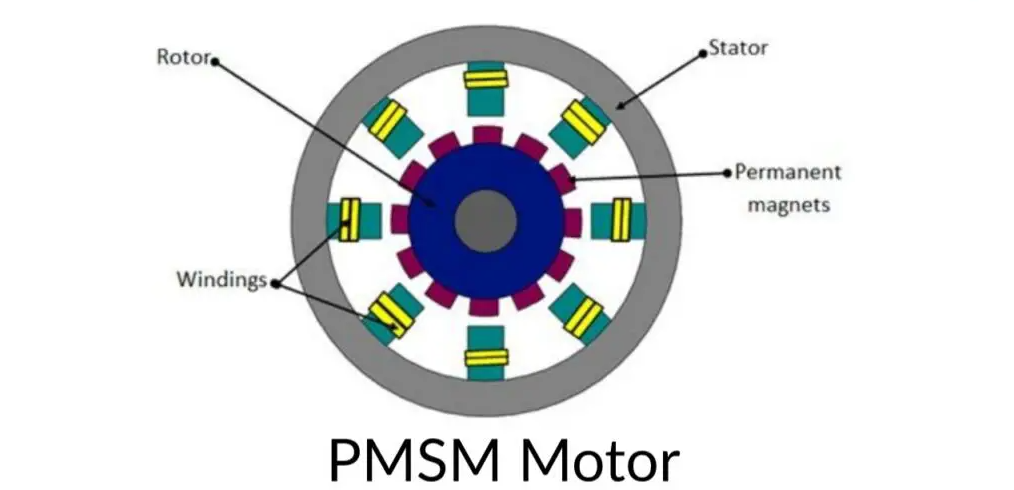

Why is the correlation between pm and stator_winding, stator_yoke, and ambient is so high?

First of all, all of them are temperatures.

As we see from the picture above, the magnets are inside the stator(both yoke and windings). This leads to a strong thermal coupling within the motor.

Heat is mainly generated in the stator windings and then propagates through the stator yoke and across the air gap to the rotor, directly affecting the magnets. At the same time, ambient temperature influences how efficiently heat can be dissipated from the motor, shifting the overall thermal equilibrium.

As a result, these components respond similarly to operating conditions, leading to highly correlated temperature trends despite their different physical locations.

I made the second dataset using only the features with correlation between 0.3 and 0.8 with pm.

In [6]:
df_second = df[['stator_winding', 'stator_yoke', 'ambient', 'pm']]

Here I create X by which I'll predict y - target feature(pm).

In [7]:
X = df.drop(['pm'], axis=1, inplace=False)
y = df[['pm']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

Normalize the data(otherwise the numbers are very large)

In [18]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std

The from-scratch implementation of Linear Regression + predict and score functions.

In [32]:
class Lin_reg:

  def __init__(self):
    self.params__ = None

  def gradient_descent(self, X, y, learning_rate=1e-4, iterations=500, batch_size=16):
    X = np.concatenate([X, np.ones_like(y)], axis = 1)
    rows, cols = X.shape
    X = np.append(X, y, axis=1)
    weights = np.random.random((cols, 1)) * 0.001

    for i in range(iterations):
      np.random.shuffle(X)
      y_it = X[:, -1].reshape((rows, 1))
      X_it = X[:, :-1]

      for batch in range(math.ceil(rows / batch_size)):
        batch_start = batch * batch_size
        x_batch = X_it[batch_start : min(batch_start + batch_size, X.shape[0])]
        y_batch = y_it[batch_start : min(batch_start + batch_size, X.shape[0])]

        weights -= learning_rate * np.matmul(x_batch.transpose(),
         (np.matmul(x_batch, weights) - y_batch)) / x_batch.shape[0]

    self.params__= weights
    return self

  def predict(self, X):
    X = np.concatenate([X, np.ones(X.shape[0]).reshape((X.shape[0], 1))], axis=1)
    return np.matmul(X, self.params__)

  def score(self, X, y):
    y = y.reshape(-1, 1)
    y_pred = self.predict(X)
    y_mean = np.mean(y)
    return float(1 - ((y - y_pred)** 2).sum() / ((y - y_mean)** 2).sum())

Training the linear regression from sklearn.

In [ ]:
lr1 = LinearRegression()

lr1.fit(X_train, y_train)

Training the linear regression from-scratch. (batch size is huge because I have > 1e+6, otherwise it would take an eternity)

In [ ]:
lr2 = Lin_reg()

lr2.gradient_descent(X_train, y_train, learning_rate=1e-2, iterations=100, batch_size=10000)

Scoring the sklearn Linear Regression.

In [21]:
lr1.score(X_test, y_test)

0.8559644783116358

Scoring Linear Regression from-scratch.

In [25]:
lr2.score(X_test, y_test)

np.float64(0.834121095865516)

The score of my model is a little bit lower, but anyway, pretty good and close to the sklearn implementation.

Here I create X by which I'll predict y - target feature(pm).

In [26]:
X = df_second.drop(['pm'], axis=1, inplace=False)
y = df_second[['pm']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

Normalizing the data.

Why do I use the same X_mean and X_std for X_test and X_train? Because I need to interpret the test as unseen data -> I need to normalize it according to the same measures.

In [27]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std

Training sklearn Linear Regression.

In [ ]:
lr1 = LinearRegression()

lr1.fit(X_train, y_train)

Training Linear Regression from-scratch.

In [ ]:
lr2 = Lin_reg()

lr2.gradient_descent(X_train, y_train, learning_rate=1e-2, iterations=100, batch_size=10000)

In [30]:
lr1.score(X_test, y_test)

0.7032203771296599

In [34]:
lr2.score(X_test, y_test)

0.703220619664064

The model created performs even slightly better than the sklearn model!

To conclude, the performance of Linear Regression for this data was pretty good - 0.7 - 0.85.

The sklearn implementation was better when all the features were present, but when there present only highly-correlated features, its performance was similar to the implementation from-scratch.

Overall, the performance of Linear Regression decreased when there were only higly-correlated features.

This can be explained by the fact that correlation analysis considers each feature independently, while linear regression benefits from the combined effect of multiple features. As a result, some features with lower individual correlation still contributed useful complementary information, and removing them led to a loss in predictive power.